# CLIP Enhanced CycleGAN

## Introduction
Image-to-image translation aims to learn a mapping between images from a source domain to a
target domain. While many deep learning techniques rely on paired training data, Cycle-Consistent
Adversarial Networks (CycleGAN) offer a better approach for unpaired image-to-image translation.
This project will focus on applying CycleGAN to the task of translating paintings by Monet into
photorealistic images, utilizing the publicly accessible monet2photo dataset. To demonstrate a
deeper understanding beyond standard implementation, this project will use a contrastively pre-trained language-image model (CLIP) with frozen weights. CLIP offers a promising avenue for simplifying the CycleGAN framework, improving its robustness, and enhancing the quality of image-to-image translation. It can potentially address some of the inherent challenges of GAN training and lead to more effective and efficient models.

## Dataset

In [27]:
import torch
import os
from torch import nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader
from torchvision import transforms
from monet2photo_dataset import Monet2PhotoDataset
import matplotlib.pyplot as plt

In [28]:
# Define transforms
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

# Load datasets
dataset_A = Monet2PhotoDataset(root_dir="../data/monet2photo", domain="A", mode="test", transform=transform)
dataset_B = Monet2PhotoDataset(root_dir="../data/monet2photo", domain="B", mode="test", transform=transform)

loader_A = DataLoader(dataset_A, batch_size=1, shuffle=False)
loader_B = DataLoader(dataset_B, batch_size=1, shuffle=False)

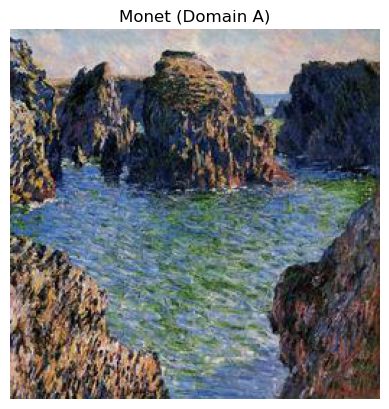

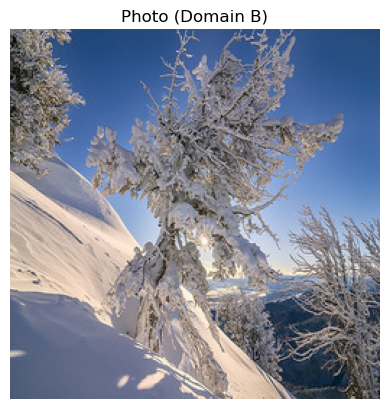

In [49]:
# Show sample images
def display_image(tensor, title="Image"):
    image = tensor.squeeze(0).permute(1, 2, 0).detach().numpy()
    plt.imshow(image)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Display one pair
for img_A, img_B in zip(loader_A, loader_B):
    display_image(img_A, "Monet (Domain A)")
    display_image(img_B, "Photo (Domain B)")
    break

In [31]:
# Setup paths
model_path = os.path.abspath(os.path.join("models"))
data_path = os.path.abspath(os.path.join("data", "monet2photo"))
os.makedirs("checkpoints", exist_ok=True)

# Load Generator class
import sys
if model_path not in sys.path:
    sys.path.append(model_path)
from generator import Generator

if data_path not in sys.path:
    sys.path.append(data_path)
from monet2photo_dataset import Monet2PhotoDataset

In [ ]:
# Check how many images we have
print(len(os.listdir("monet2photo/trainA")))
print(len(os.listdir("monet2photo/trainB"))) 

1072
6287


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Loading data
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

dataset_A = Monet2PhotoDataset("monet2photo", domain="A", mode="train", transform=transform)
dataset_B = Monet2PhotoDataset("monet2photo", domain="B", mode="train", transform=transform)

loader_A = DataLoader(dataset_A, batch_size=1, shuffle=True)
loader_B = DataLoader(dataset_B, batch_size=1, shuffle=True)

In [ ]:
# Initializing Generator and Optimizer
G_A2B = Generator().to(device)
optimizer = torch.optim.Adam(G_A2B.parameters(), lr=2e-4, betas=(0.5, 0.999))
criterion = nn.L1Loss()

# Training loop - 1 epoch for now
G_A2B.train()
for step, (img_A, img_B) in enumerate(zip(loader_A, loader_B)):
    img_A, img_B = img_A.to(device), img_B.to(device)

    fake_B = G_A2B(img_A)
    loss = criterion(fake_B, img_B)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    print(f"Step {step+1}: Loss = {loss.item():.4f}")

    if step == 10:  # for ten steps
        break

# Saving model
torch.save(G_A2B.state_dict(), "checkpoints/G_A2B.pth")
print("Model saved as checkpoints/G_A2B.pth")

Step 1: Loss = 0.4252
Step 2: Loss = 0.3627
Step 3: Loss = 0.2778
Step 4: Loss = 0.2610
Step 5: Loss = 0.2018
Step 6: Loss = 0.2235
Step 7: Loss = 0.3450
Step 8: Loss = 0.1282
Step 9: Loss = 0.1266
Step 10: Loss = 0.1449
Step 11: Loss = 0.3598
Model saved as checkpoints/G_A2B.pth


In [50]:
# Display our images side by side
def show_image(img1, img2=None, title1="Monet (Domain A)", title2="Photo (Domain B)"):
    if img1.dim() == 4:
        img1 = img1.squeeze(0)
    if img2 is not None and img2.dim() == 4:
        img2 = img2.squeeze(0)

    img1 = img1.permute(1, 2, 0).detach().cpu().numpy()
    
    if img2 is not None:
        img2 = img2.permute(1, 2, 0).detach().cpu().numpy()
        fig, axes = plt.subplots(1, 2, figsize=(8, 4))
        axes[0].imshow(img1)
        axes[0].set_title(title1)
        axes[0].axis("off")
        axes[1].imshow(img2)
        axes[1].set_title(title2)
        axes[1].axis("off")
    else:
        plt.imshow(img1)
        plt.title(title1)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [51]:
# Load trained weights
G_A2B.load_state_dict(torch.load("checkpoints/G_A2B.pth", map_location=device))
G_A2B.eval()

/var/folders/tc/wl6k8hsd2cl4l1d2_qncs5cm0000gn/T/ipykernel_67311/904244384.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  G_A2B.load_state_dict(torch.load("checkpoints/

Generator(
  (initial): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (down1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (down2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (2): ReLU(inplace=True)
  )
  (res_blocks): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (in1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (relu): ReLU(inplace=Tr

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


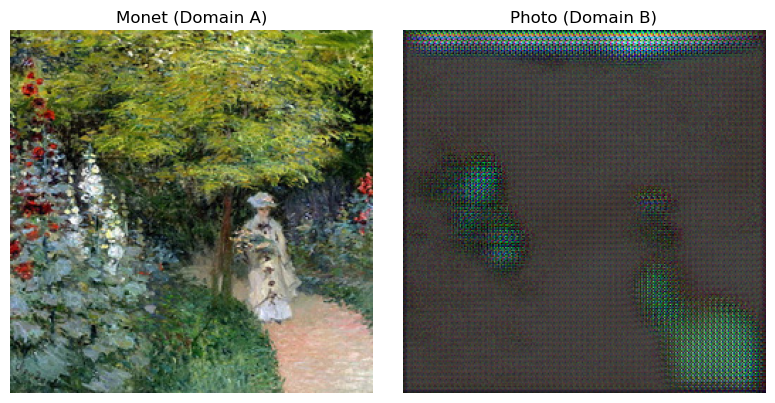

In [53]:
# Get one sample from test loader
real_photo = next(iter(loader_A)).to(device)

# Inference
with torch.no_grad():
    fake_monet = G_A2B(real_photo)

# Save images side-by-side
os.makedirs("../outputs", exist_ok=True)
save_image(torch.cat([real_photo, fake_monet], dim=0), "../outputs/monet_to_photo.jpg", nrow=2, normalize=True)

show_image(real_photo, fake_monet)